In [32]:
# conda activate chronocell

import os
import sys
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sys.path.append(os.path.abspath("code"))
from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")
# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [2]:
random_seed = 0

In [50]:
# === Splicing rate ===
beta_mu = 2 # np.log(splicing_rate) # (Corresponds to ~8.5 minute splicing rate, per Chronocell paper)
beta_sd = 0.5

# ==== Transcription rate ====
alpha_mu = 2 # (Corresponds to ~7 mRNAs/hour, per Chronocell paper)
alpha_sd = 1

# === mRNA degradation rate ===
gamma_mu = 0.5 # (Corresponds to ~2.8 hour half-life, per Chronocell paper)
gamma_sd = 0.5

# === Translation rate === 
median_transl_rate = 30 # (per Jovanovic paper)
transl_rate_mu = np.log(median_transl_rate)
transl_rate_sd = 1

# === Protein degradation rate === 
protein_deg_rate = .01 # (per Jovanovic paper)
protein_deg_rate_mu = np.log(protein_deg_rate) # Median of lognormal
protein_deg_rate_sd = 1.5

# # # Read depth
# rd_mu = 0.25
# rd_var = 1/64

In [51]:
# Simulate data

n = 1000 # No. cells per lineage
p = 200 # No. genes
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 2, 6)

theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, protein_deg_rate_mu, protein_deg_rate_sd, random_seed=random_seed)
Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)
P_observed, P = simulate_protein_from_RNA(Y_observed, topo, true_t, true_l, phi, random_seed=random_seed)

In [52]:
Y_observed[:, :, 1]

array([[21, 18,  1, ...,  1,  5,  2],
       [20, 12,  7, ...,  2,  5,  4],
       [12, 19,  8, ...,  0,  7,  1],
       ...,
       [34,  7, 31, ...,  7,  5,  3],
       [26,  2, 28, ...,  2,  9,  1],
       [32,  1, 19, ...,  7,  8,  1]])

In [53]:
np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])

/tmp/ipykernel_3350611/845268906.py:1: RuntimeWarning: divide by zero encountered in divide
  np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])
/tmp/ipykernel_3350611/845268906.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])


np.float64(0.16666666666666666)

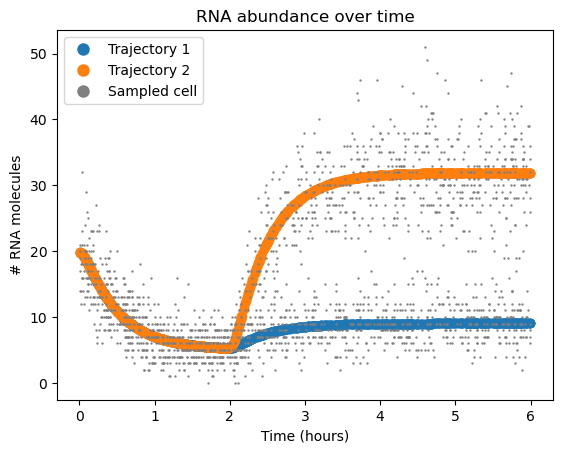

In [54]:
idx = 0
mask_0 = true_l == 0
mask_1 = true_l == 1

# === Plot example RNA trajectory ===

plt.scatter(true_t[mask_0], Y[mask_0, idx, 1])
plt.scatter(true_t[mask_1], Y[mask_1, idx, 1])
plt.scatter(true_t, Y_observed[:, idx, 1], s=.5, color="gray")

plt.xlabel("Time (hours)");
plt.ylabel("# RNA molecules")
plt.title("RNA abundance over time");

custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Trajectory 1', markerfacecolor='tab:blue', markersize=10),  # big marker
    Line2D([0], [0], marker='o', color='w', label='Trajectory 2', markerfacecolor='tab:orange', markersize=10), # small marker
    Line2D([0], [0], marker='o', color='w', label='Sampled cell', markerfacecolor='gray', markersize=10)  # tiny marker
]
plt.legend(handles=custom_handles)

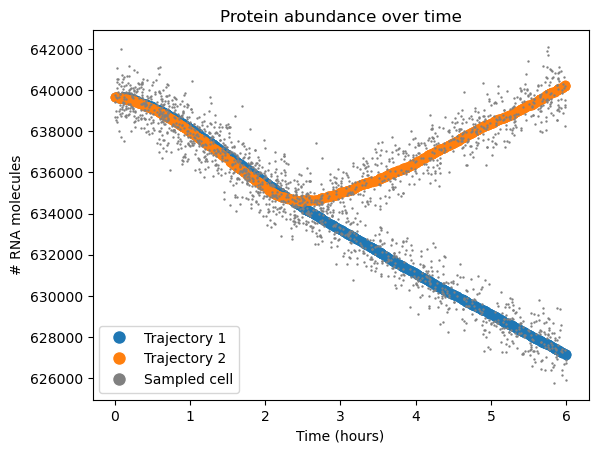

In [55]:
# === Plot example protein trajectory for same gene ===
plt.scatter(true_t[mask_0], P[mask_0, idx], color='tab:blue', label='Trajectory 1')
plt.scatter(true_t[mask_1], P[mask_1, idx], color='tab:orange', label='Trajectory 2')
plt.scatter(true_t, P_observed[:, idx], s=.5, color="grey", label="Sampled cells")

plt.xlabel("Time (hours)");
plt.ylabel("# RNA molecules")
plt.title("Protein abundance over time");

custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Trajectory 1', markerfacecolor='tab:blue', markersize=10),  # big marker
    Line2D([0], [0], marker='o', color='w', label='Trajectory 2', markerfacecolor='tab:orange', markersize=10), # small marker
    Line2D([0], [0], marker='o', color='w', label='Sampled cell', markerfacecolor='gray', markersize=10)  # tiny marker
]
plt.legend(handles=custom_handles)

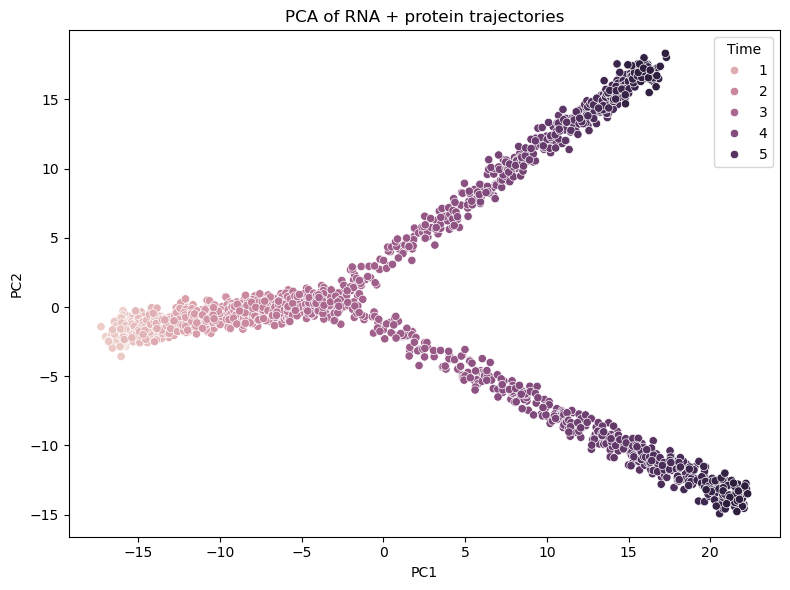

In [ ]:
# PCA on cells 

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Y_norm = stats.zscore(Y_observed[:, :, 1])
P_norm = stats.zscore(P_observed)

# === Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_norm, P_norm], axis=1)
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

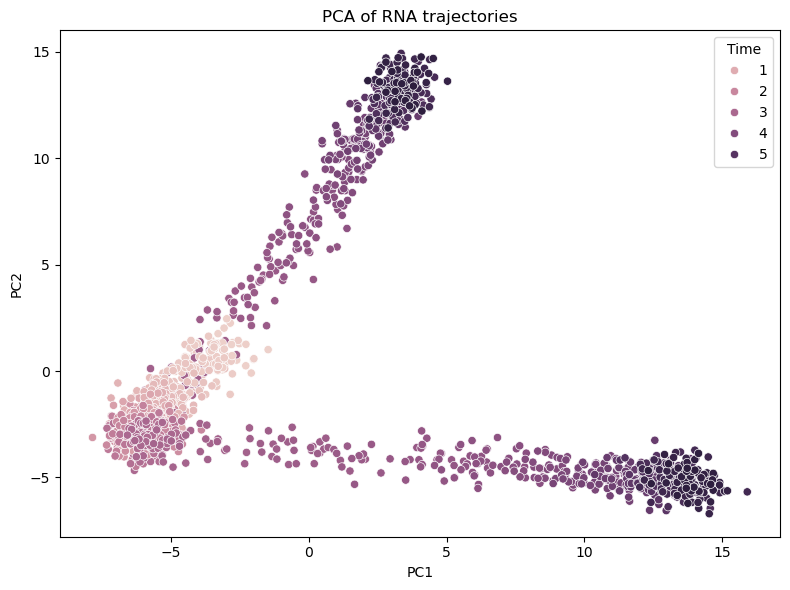

In [37]:
# === RNA for PCA ===
combined_traj = Y_norm
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

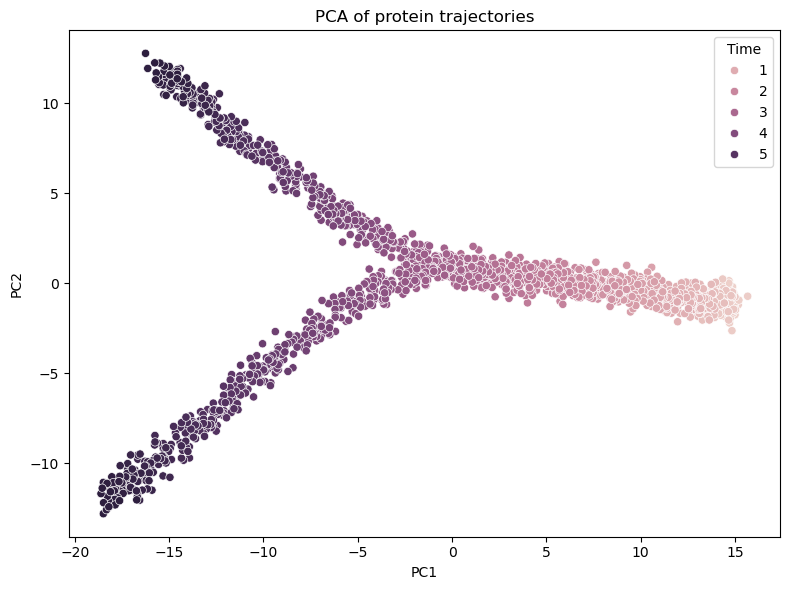

In [38]:
# === Protein for PCA ===
combined_traj = P_norm
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [84]:
# Calculate RNA vs. protein correlation for each gene per trajectory

rows = []
for i in range(p):
    y_i = Y_observed[:, i, 1]
    p_i = P_observed[:,i]
   
    steady_state = theta[i, 0]
    alpha_vals = theta[i, 1:-2]  # all columns after steady_state up to beta
    beta = theta[i, -2]
    gamma = theta[i, -1]
   
    cor_vals = []
    for l in set(true_l):
        mask = true_l == l
        cor_vals.append(np.corrcoef(y_i[mask], p_i[mask])[0, 1])
        
    row = {
        'Cor': np.corrcoef(y_i, p_i)[0, 1],
        'Steady_state': steady_state,
        'Beta': beta,
        'Gamma': gamma,
        'Translation_rate': phi[i, 0],
        'Degradation_rate': phi[i, -1]
    }
        
    for j, val in enumerate(alpha_vals, 1):
        row[f'Alpha {j}'] = val
        
    for j, val in enumerate(cor_vals, 1):
        row[f'Cor {j}'] = val
    
    rows.append(row)

data = pd.DataFrame(rows)

param_cols = data.columns.values[1:data.shape[0]]

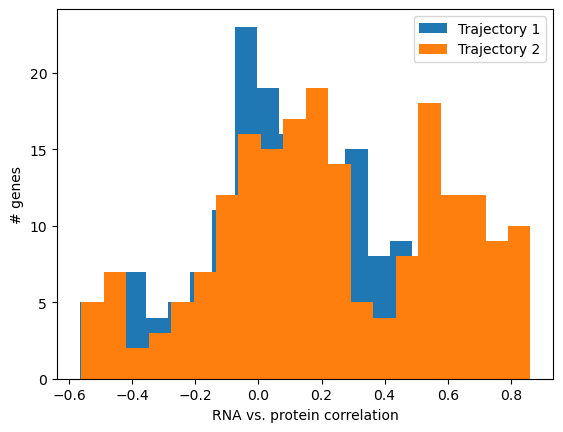

In [85]:
for i in set(map(int, true_l)):
    plt.hist(data[f'Cor {i + 1}'], bins=20, label=f"Trajectory {i + 1}");

plt.xlabel("RNA vs. protein correlation");
plt.ylabel("# genes");
plt.legend();

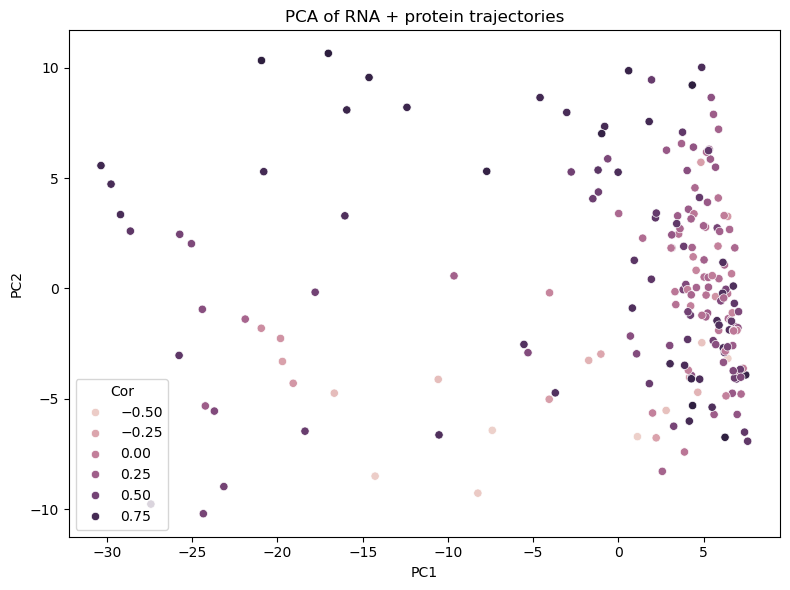

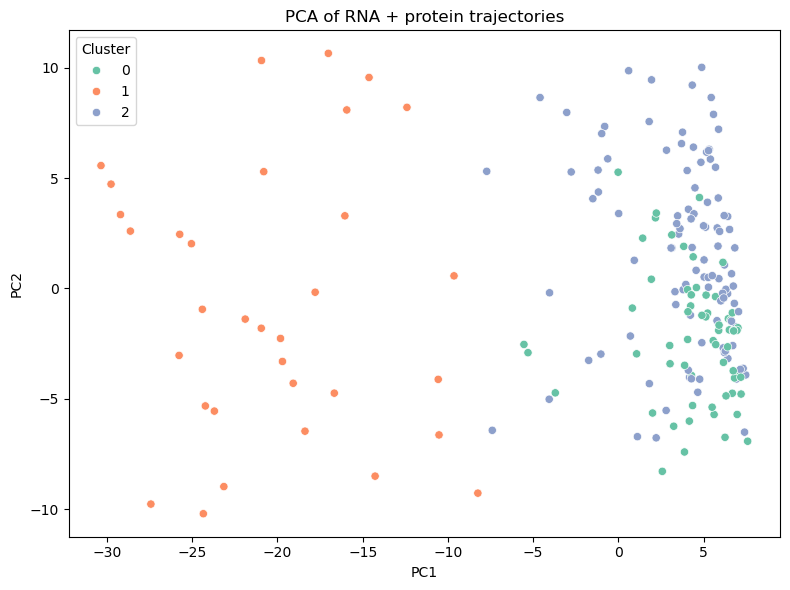

              Cor  Steady_state      Beta     Gamma  Translation_rate  \
Cluster                                                                 
2        0.280622      2.214107  8.335491  1.873692         57.397953   
0        0.375284      1.327332  9.367757  1.856339         46.754688   
1        0.385095      0.468362  7.927753  2.233633         54.829202   

         Degradation_rate   Alpha 1   Alpha 2   Alpha 3     Cor 1     Cor 2  \
Cluster                                                                       
2                0.019187  1.726245  0.896457  1.906987  0.151546  0.225984   
0                0.014782  0.971097  2.742269  1.107761  0.280309  0.212029   
1                0.046200  1.761795  1.476294  2.678274  0.059182  0.281441   

               PC1       PC2  
Cluster                       
2         3.788000  1.468170  
0         4.354225 -2.223010  
1       -20.216233 -0.606738  


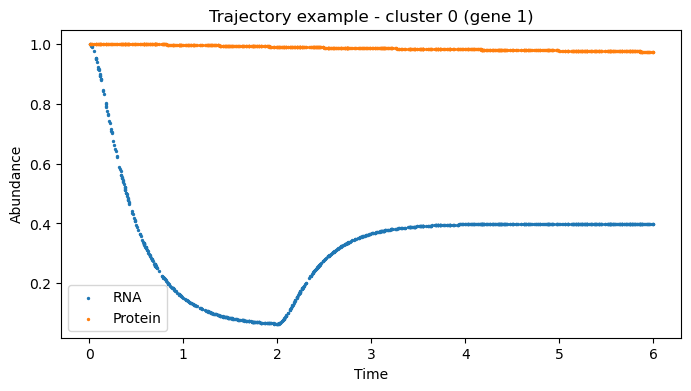

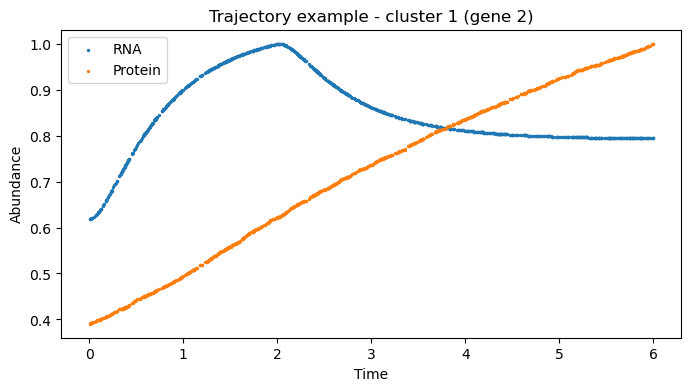

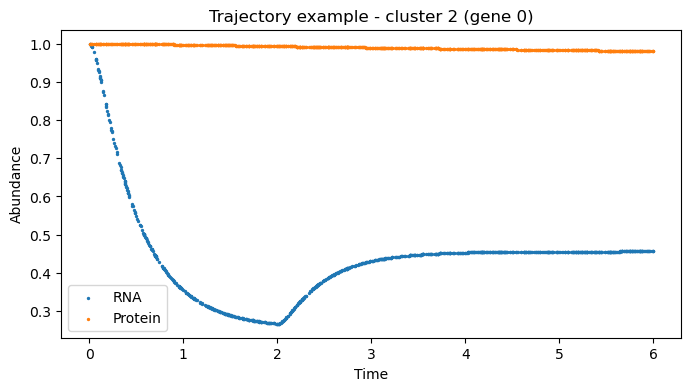

In [ ]:
# PCA on genes 

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Y_norm = Y_observed[:, :, 1] / np.max(Y_observed[:, :, 1], axis=0)
P_norm = P_observed / np.max(P_observed, axis=0)

# === Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_norm, P_norm], axis=0)
pca = PCA(n_components=3)
traj_pca = pca.fit_transform(combined_traj.T)

kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(traj_pca)
data['PC1'] = traj_pca[:, 0]
data['PC2'] = traj_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cor')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cluster', palette='Set2')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

print(data.groupby('Cluster').mean().sort_values('Cor'))

# Plot representative gene trajectories from each cluster
for c in sorted(data['Cluster'].unique()):
    idx = data[data['Cluster'] == c].index[0]  # random gene in cluster
    plt.figure(figsize=(8, 4))
    plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), label='RNA', s=2)
    plt.scatter(true_t[true_l == 0], P[:n, idx] / np.max(P[:n, idx]), label='Protein', s=2)
    plt.title(f'Trajectory example - cluster {c} (gene {idx})')
    plt.xlabel('Time')
    plt.ylabel('Abundance')
    plt.legend()
    plt.show()

In [ ]:
# === Concatenate RNA and protein for PCA ===
combined_traj = Y_norm
pca = PCA(n_components=3)
traj_pca = pca.fit_transform(combined_traj.T)

kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(traj_pca)
data['PC1'] = traj_pca[:, 0]
data['PC2'] = traj_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cor')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cluster', palette='Set2')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

print(data.groupby('Cluster').mean().sort_values('Cor'))

# Plot representative gene trajectories from each cluster
for c in sorted(data['Cluster'].unique()):
    idx = data[data['Cluster'] == c].index[0]  # random gene in cluster
    plt.figure(figsize=(8, 4))
    plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), label='RNA', s=2)
    plt.scatter(true_t[true_l == 0], P[:n, idx] / np.max(P[:n, idx]), label='Protein', s=2)
    plt.title(f'Trajectory example - cluster {c} (gene {idx})')
    plt.xlabel('Time')
    plt.ylabel('Abundance')
    plt.legend()
    plt.show()

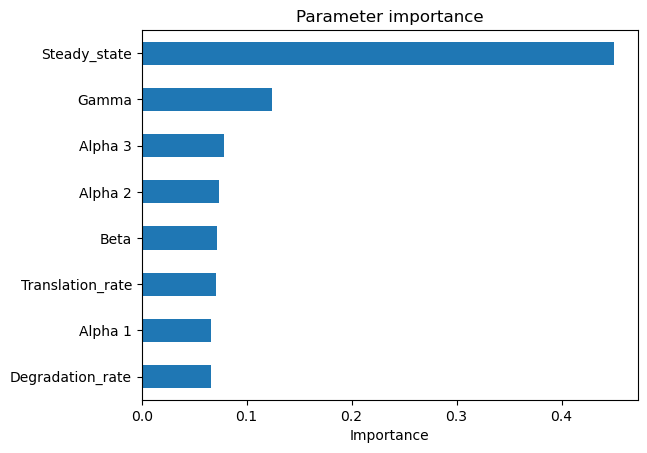

In [160]:
from sklearn.ensemble import RandomForestClassifier

X_params = data[param_cols]
y_clusters = data['Cluster']

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_params, y_clusters)

importances = pd.Series(clf.feature_importances_, index=param_cols)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Parameter importance")
plt.xlabel("Importance")
plt.show()

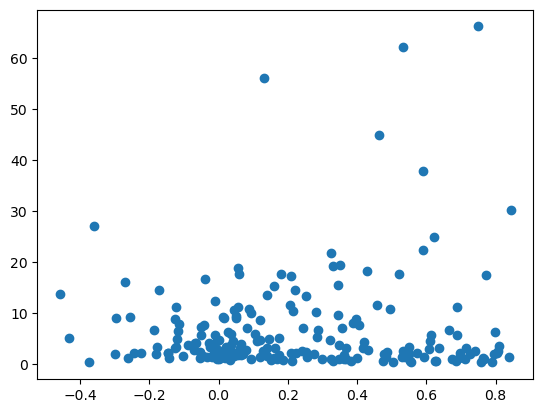

In [165]:
plt.scatter(data['Cor'], data['Steady_state'])

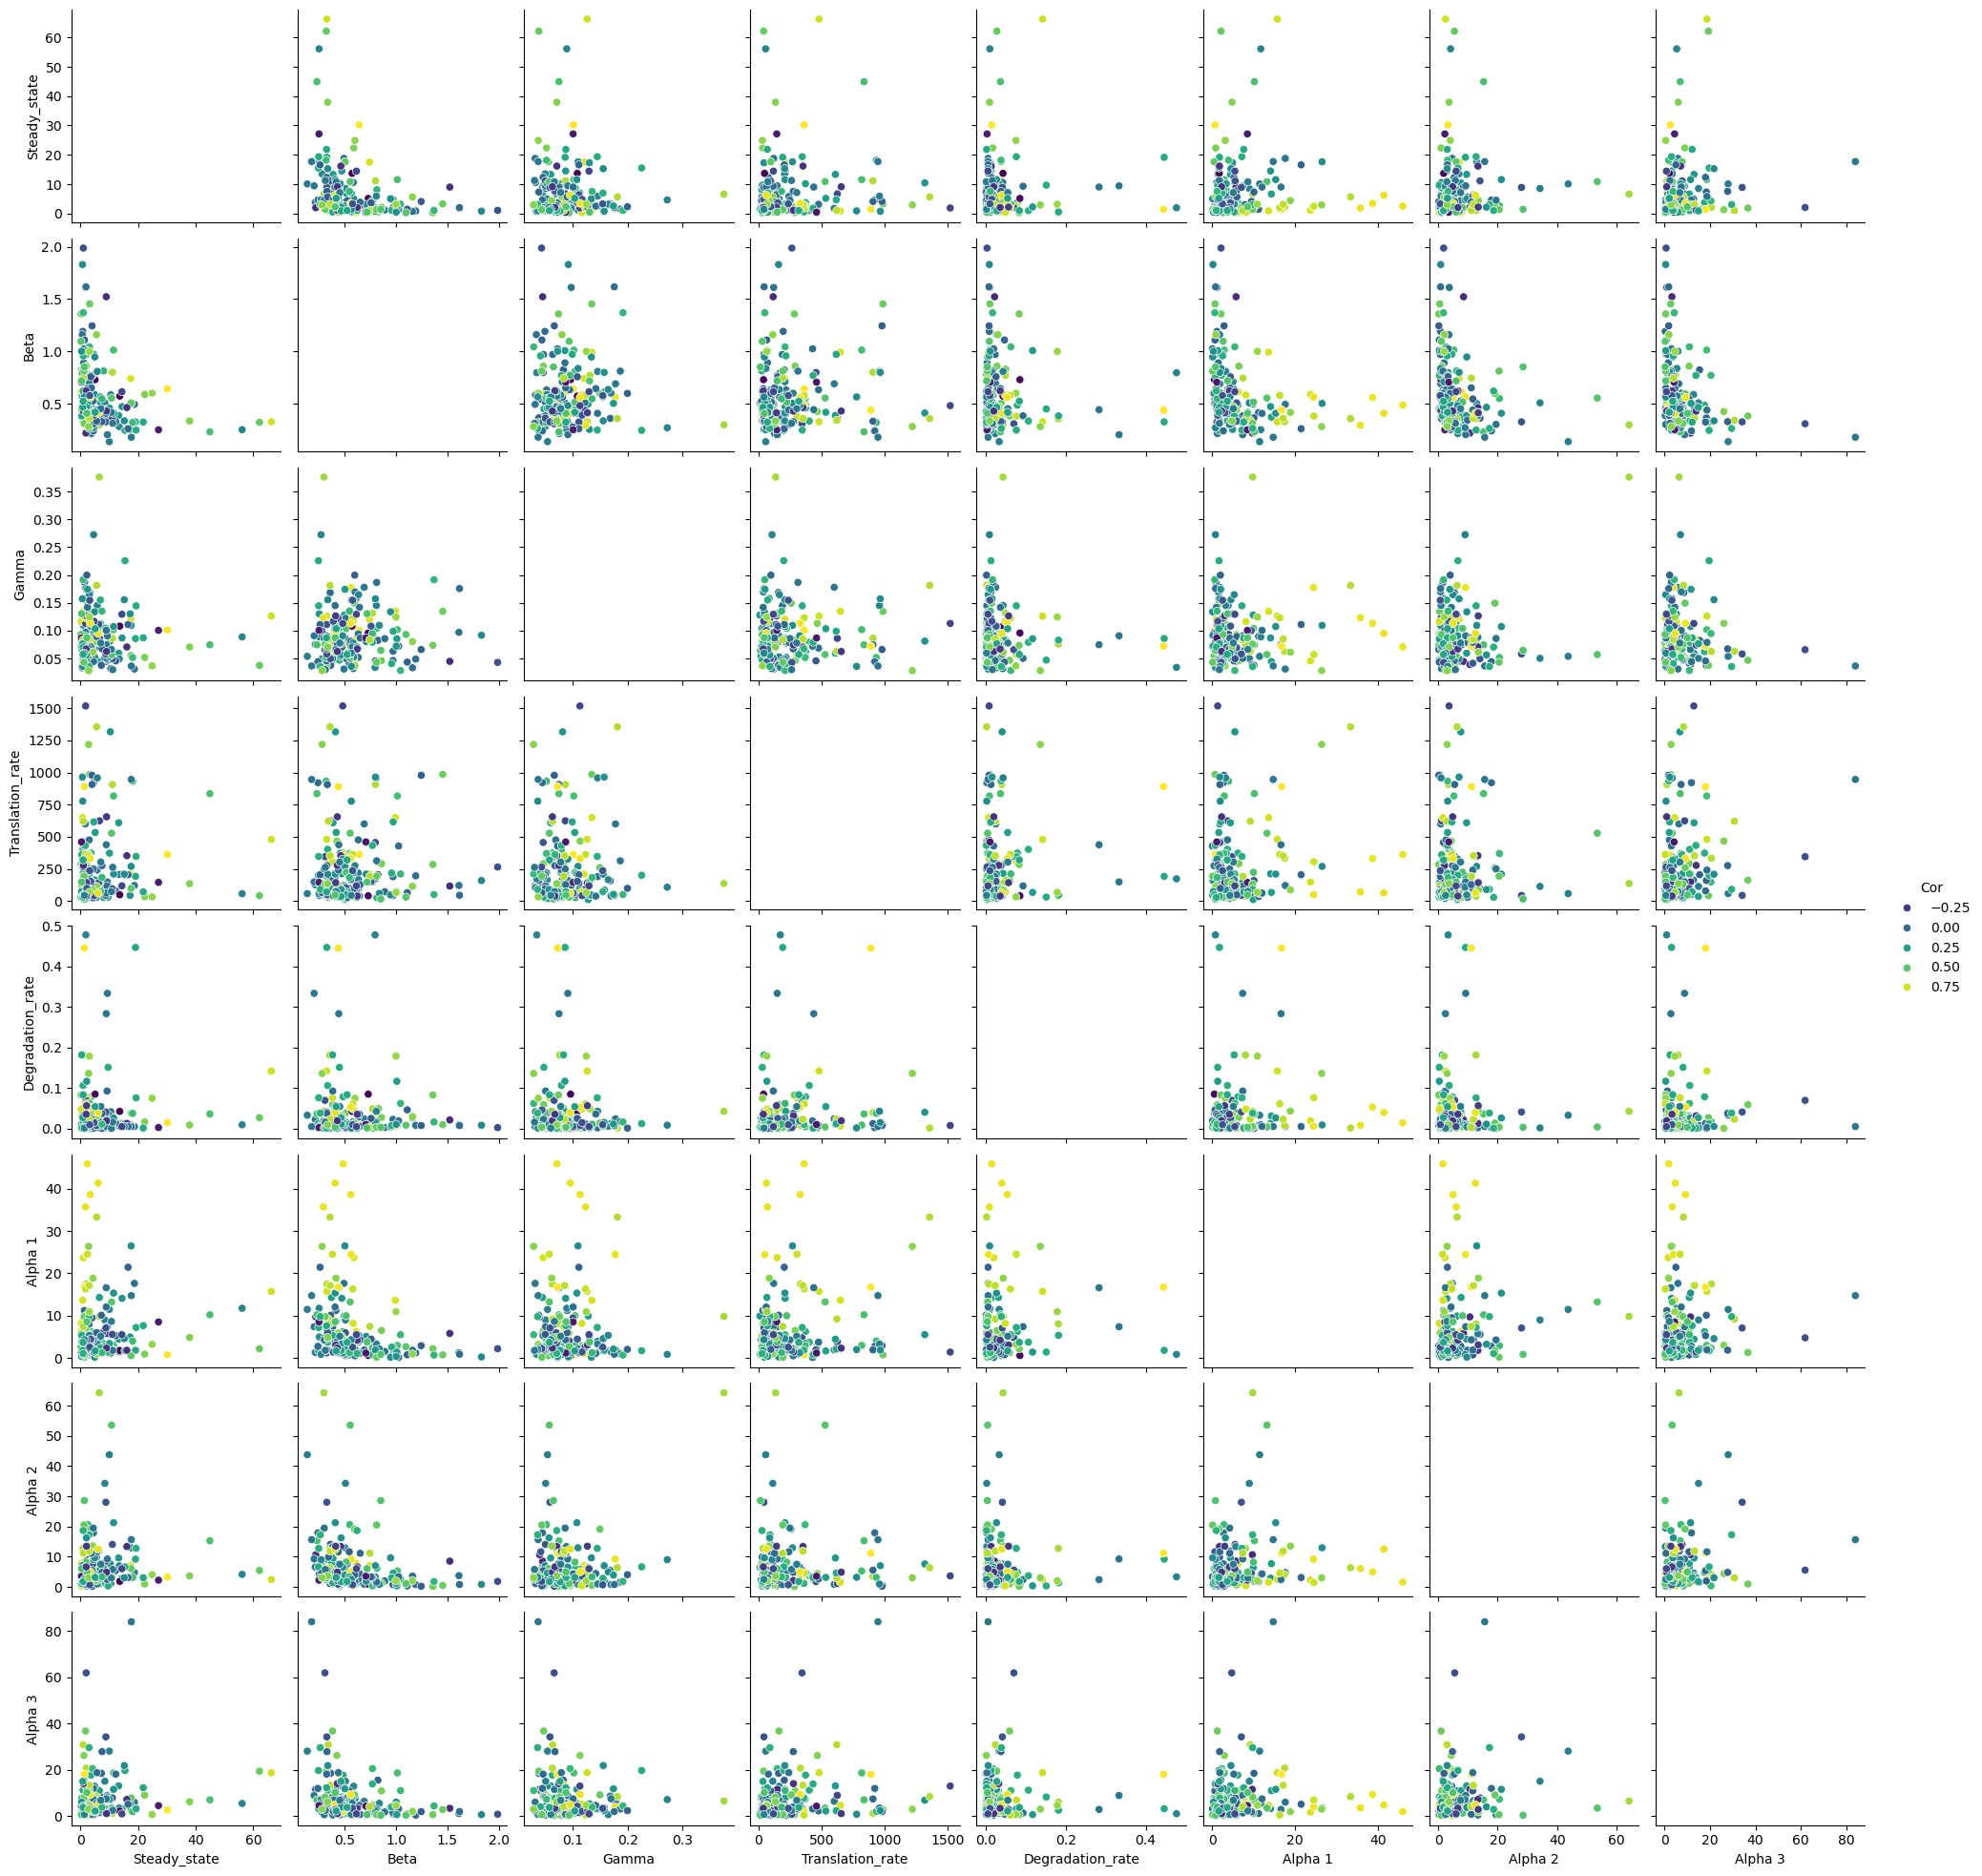

In [161]:
sns.pairplot(data, vars=param_cols, hue='Cor', palette='viridis')

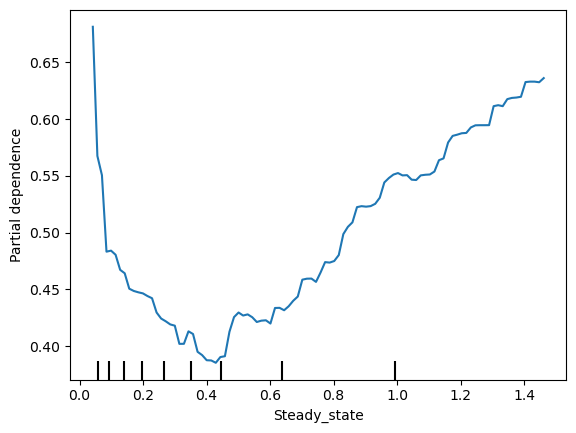

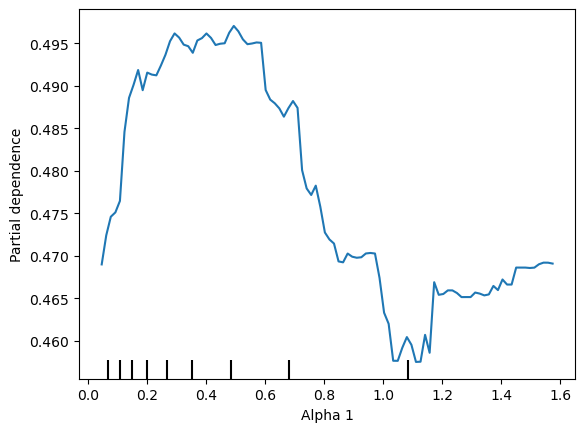

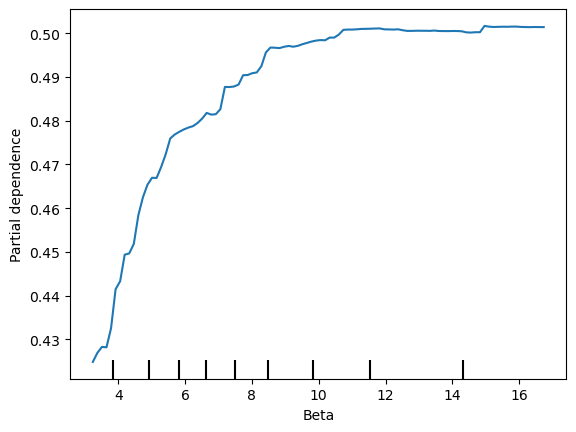

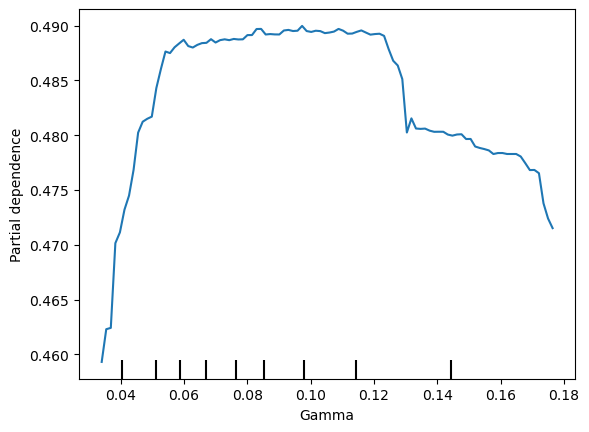

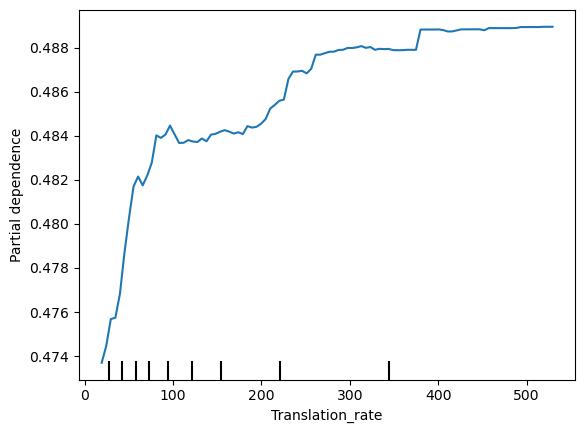

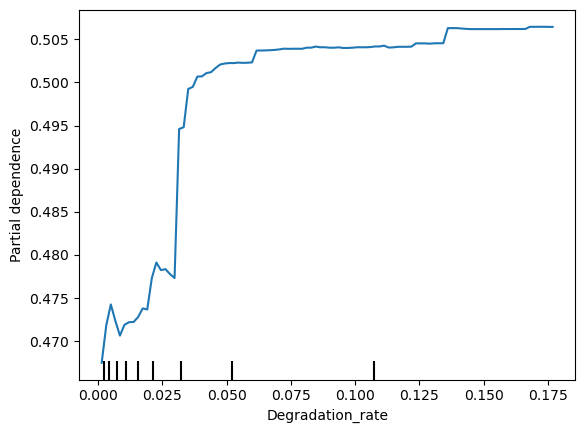

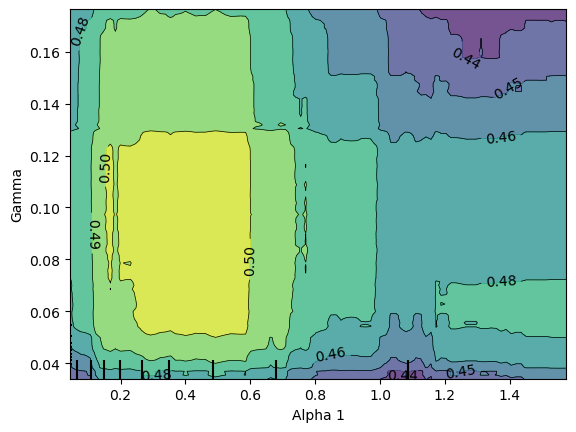

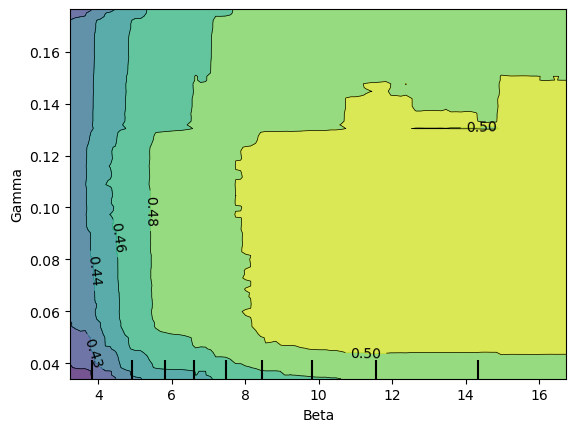

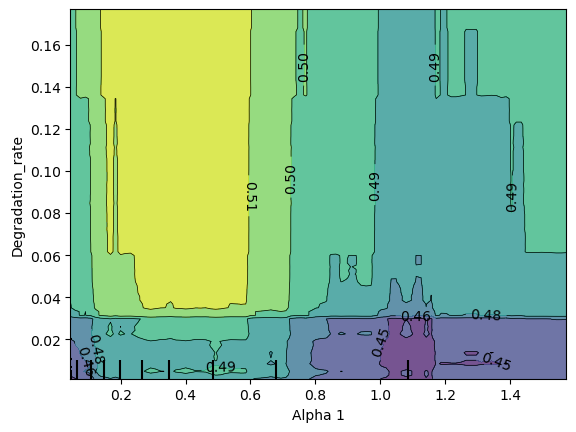

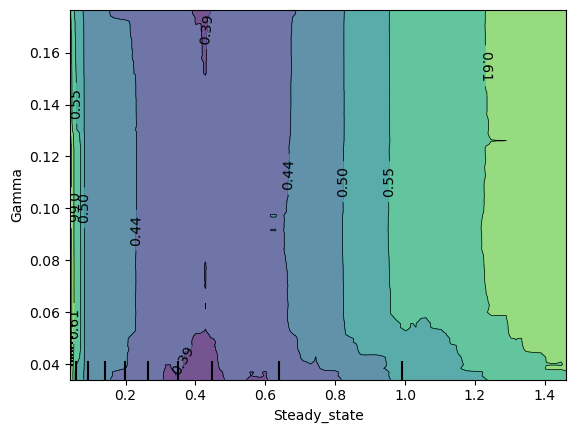

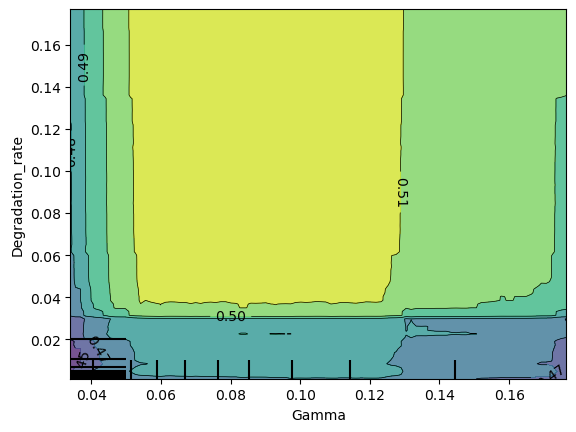

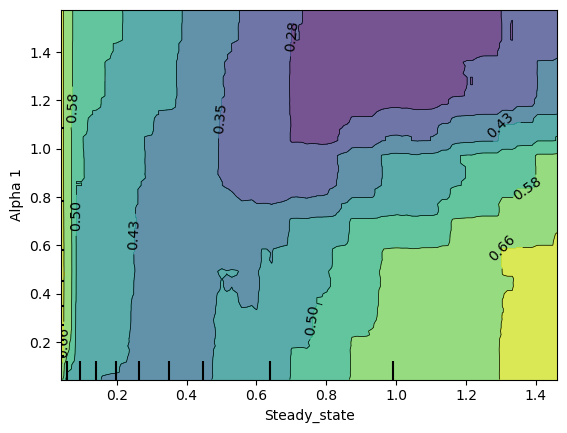

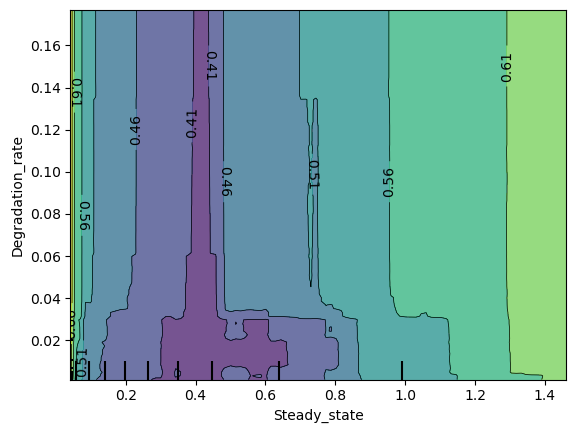

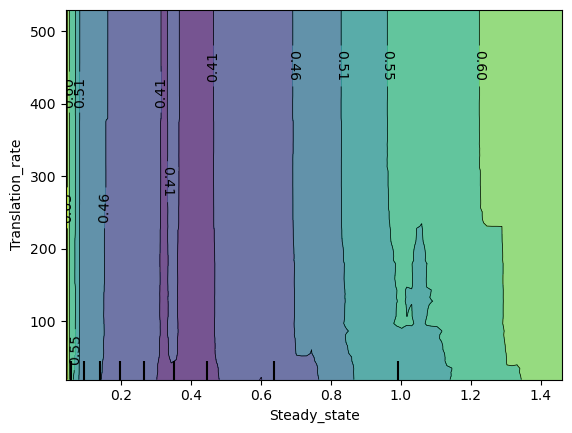

In [280]:
from sklearn.inspection import PartialDependenceDisplay

X = data[param_cols]
y = data['Cor']

model = RandomForestRegressor(n_estimators=100, max_depth=len(param_cols), random_state=0)
model.fit(X, y)

# PDP plots

PartialDependenceDisplay.from_estimator(model, X, features=['Steady_state'])
PartialDependenceDisplay.from_estimator(model, X, features=['Alpha 1'])
PartialDependenceDisplay.from_estimator(model, X, features=['Beta'])
PartialDependenceDisplay.from_estimator(model, X, features=['Gamma'])
PartialDependenceDisplay.from_estimator(model, X, features=['Translation_rate'])
PartialDependenceDisplay.from_estimator(model, X, features=['Degradation_rate'])

PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha 1', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Beta', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha 1', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Gamma', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Alpha 1')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Translation_rate')])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = data[param_cols]
y = data['Cor']

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Generate polynomial interaction features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit linear regression on polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Get interaction term names
feature_names = poly.get_feature_names_out(X.columns)  # X must be a DataFrame
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(15))

# Make predictions
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Gamma Alpha 1                   -1.465908
Gamma Alpha 3                    1.414268
Gamma Degradation_rate           1.265081
Degradation_rate                -0.552040
Degradation_rate Alpha 3         0.510879
Steady_state                     0.398816
Degradation_rate Alpha 2        -0.269143
Steady_state Alpha 1            -0.252694
Gamma                            0.227781
Steady_state Degradation_rate   -0.167656
Degradation_rate Alpha 1         0.130944
Alpha 1                          0.122564
Alpha 2 Alpha 3                 -0.110348
Beta Degradation_rate            0.099591
Steady_state Alpha 2            -0.088639
dtype: float64
Mean Squared Error: 0.0715381607255353
R-squared: 0.21644404054193123


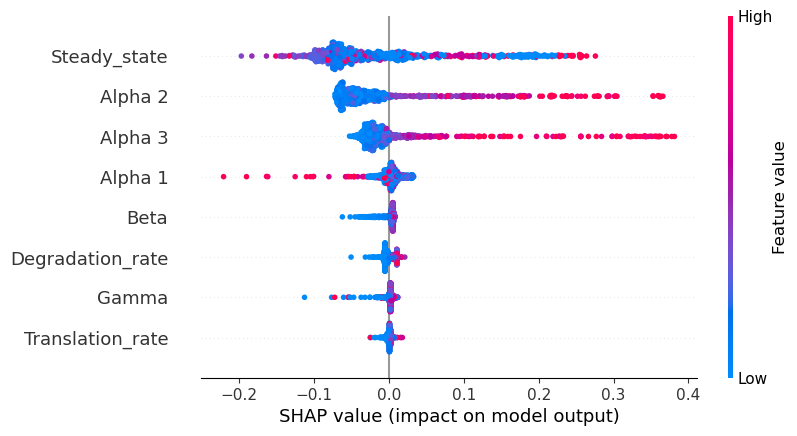

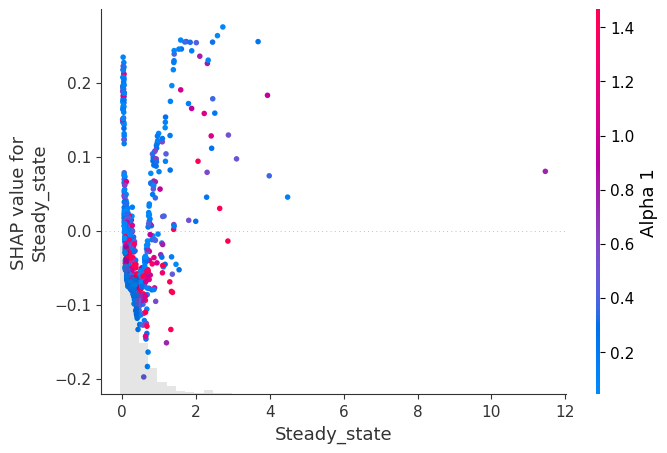

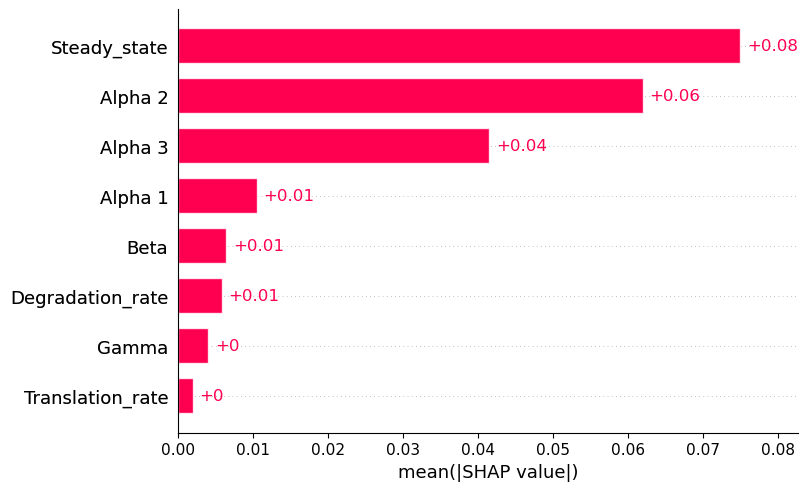

In [283]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Prepare features and target
X = data[param_cols]
y = data['Cor']

# 2. Train/test split (optional but recommended for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3. Fit Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

# 4. Create SHAP explainer with new API
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)  # Explanation object

# 5. Plot summary (beeswarm)
shap.plots.beeswarm(shap_values, max_display=10)

# 6. Plot dependence (e.g. Gamma vs Cor, colored by Translation_rate)
shap.plots.scatter(shap_values[:, "Steady_state"], color=shap_values[:, "Alpha 1"])

# 7. If you want bar plot of mean |SHAP| values:
shap.plots.bar(shap_values, max_display=10)
